# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Ioa | Last Name | Signature | Hours | Contribution |
| Member 2: | Ashish | Naik | AshishNaik, Nov5 | 3.5 | 25% |
| Member 3: | First Name | Last Name | Signature | Hours | Contribution |
| Member 4: | First Name | Last Name | Signature | Hours | Contribution |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

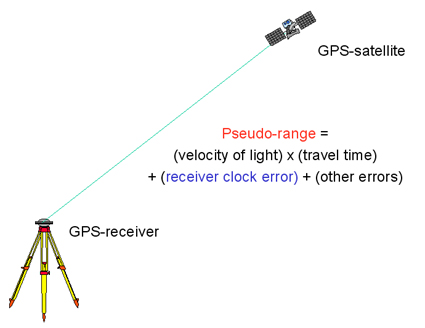

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

In [1]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 0.1: Import necessary libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [3]:
df_pseudorange = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content//drive/My Drive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [4]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [5]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [6]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [7]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
#def cost_function(r_pos, cdT, s_pos, pseudorange):

def cost_function(r_pos, cdT, s_pos, pseudorange):
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT #using receiver's coordinates and closck offset
    residuals = pseudorange - predicted_pseudorange
    L = np.sum(residuals**2)  # Cost function that computes the sum of squared residuals

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [8]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)


def gradient(r_pos, cdT, s_pos, pseudorange):
    grad = np.zeros(4)
    epsilon = 1e-6

    L_original = cost_function(r_pos, cdT, s_pos, pseudorange)

    # Gradient x_r
    r_pos_x_plus = r_pos.copy()
    r_pos_x_plus[0] += epsilon  # Perturb x_r
    L_x_plus = cost_function(r_pos_x_plus, cdT, s_pos, pseudorange)
    grad[0] = (L_x_plus - L_original) / epsilon

    # Gradient y_r
    r_pos_y_plus = r_pos.copy()
    r_pos_y_plus[1] += epsilon  # Perturb y_r
    L_y_plus = cost_function(r_pos_y_plus, cdT, s_pos, pseudorange)
    grad[1] = (L_y_plus - L_original) / epsilon

    # Gradient z_r
    r_pos_z_plus = r_pos.copy()
    r_pos_z_plus[2] += epsilon  # Perturb z_r
    L_z_plus = cost_function(r_pos_z_plus, cdT, s_pos, pseudorange)
    grad[2] = (L_z_plus - L_original) / epsilon

    # Gradient cdT
    cdT_plus = cdT + epsilon  # Perturb cdT
    L_cdT_plus = cost_function(r_pos, cdT_plus, s_pos, pseudorange)
    grad[3] = (L_cdT_plus - L_original) / epsilon

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [9]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate*grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3],s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [10]:
optimized_params = gradient_descent(pseudorange, sat_pos)

finalPositionErrorsReceiver = optimized_params[:3] - GroundTruth

FinalCostValue = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

FinalGradientValue = gradient(optimized_params[:3], optimized_params[3],sat_pos,pseudorange)

# print the mentioned metrics

print("Opmtimized Parameters: ", optimized_params)
print("Final Position Errors of Receiver: ", finalPositionErrorsReceiver)
print("Number of Steps for Convergence: ", steps_count)
print("Final Cost Value: ", FinalCostValue)
print("Final Gradient Values: ", FinalGradientValue)

Converged !
Opmtimized Parameters:  [-1.63349244e+06 -3.65162953e+06  4.95248541e+06  6.45682059e+00]
Final Position Errors of Receiver:  [-3.06381367 -2.35132297  3.78608743]
Number of Steps for Convergence:  2778
Final Cost Value:  6.197385190716741
Final Gradient Values:  [ 0.00434674  0.00453009 -0.00059258 -0.00911827]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

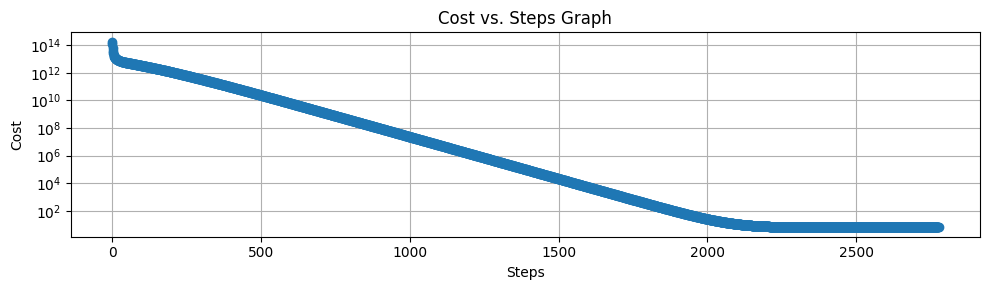

In [11]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

ax.semilogy(arr_cost, label='Cost', marker='o')
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')
ax.set_title('Cost vs. Steps Graph')

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# As the number of steps increase, the cost decreases. The constant result in cost as steps inscrease between 2300 and 2800 shows that the convergence has been sucessfull.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

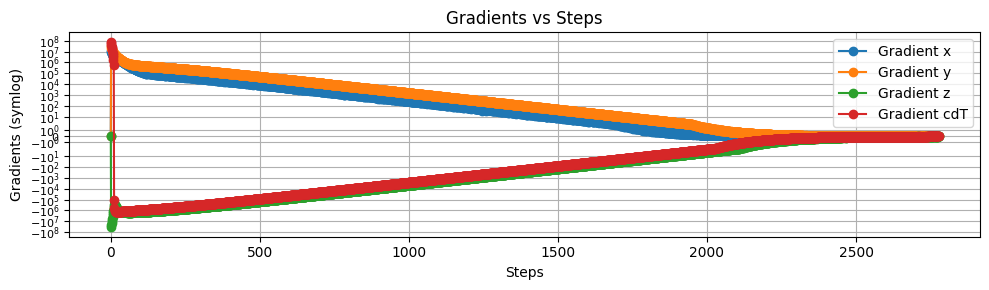

In [12]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))

gradArray = np.array(arr_grad)

ax.plot(gradArray[:,0], label='Gradient x', marker='o')
ax.plot(gradArray[:,1], label='Gradient y', marker='o')
ax.plot(gradArray[:,2], label='Gradient z', marker='o')
ax.plot(gradArray[:,3], label='Gradient cdT', marker='o')

ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)

ax.set_xlabel('Steps')
ax.set_ylabel('Gradients (symlog)')
ax.legend()
ax.set_title('Gradients vs Steps')

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# As the steps increase, the gradient converges to the final solution

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

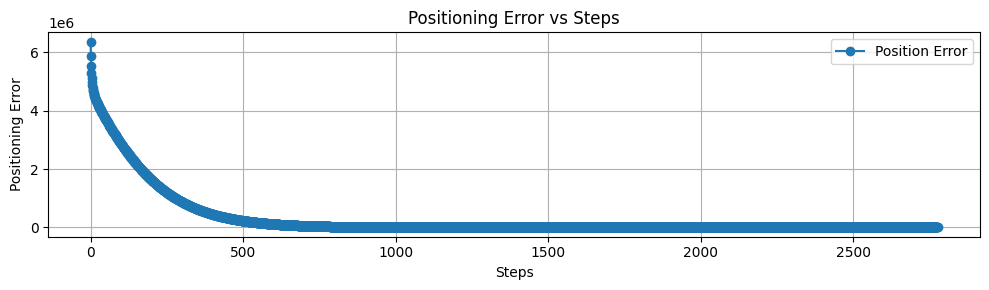

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

errorArray = np.array(arr_err)

ax.plot(np.linalg.norm(errorArray, axis=1), label='Position Error', marker='o')

ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Error')
ax.legend()
ax.set_title('Positioning Error vs Steps')

ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# In the beginning of the iteration, the position error is high. As the steps/iterations increases, the positioning error approaches 0, meaning it is reaching the final solution.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [14]:
#set learning rate to 0.01
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos,0.01)

finalPositionErrorsReceiver2 = optimized_params[:3] - GroundTruth

FinalCostValue2 = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

FinalGradientValue2 = gradient(optimized_params[:3], optimized_params[3],sat_pos,pseudorange)

# print the metrics
print("Opmtimized Parameters: ", optimized_params_2)
print("Final Position Errors of Receiver: ", finalPositionErrorsReceiver2)
print("Number of Steps for Convergence: ", steps_count)
print("Final Cost Value: ", FinalCostValue2)
print("Final Gradient Values: ", FinalGradientValue2)

Converged !
Opmtimized Parameters:  [-1.63349244e+06 -3.65162953e+06  4.95248541e+06  6.45682059e+00]
Final Position Errors of Receiver:  [-3.06381367 -2.35132297  3.78608743]
Number of Steps for Convergence:  2778
Final Cost Value:  6.197385190716741
Final Gradient Values:  [ 0.00434674  0.00453009 -0.00059258 -0.00911827]


In [15]:
#set learning rate to 0.001
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos,0.001,100000)

finalPositionErrorsReceiver3 = optimized_params[:3] - GroundTruth

FinalCostValue3 = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)

FinalGradientValue3 = gradient(optimized_params[:3], optimized_params[3],sat_pos,pseudorange)

# print the metrics
print("Opmtimized Parameters: ", optimized_params_3)
print("Final Position Errors of Receiver: ", finalPositionErrorsReceiver3)
print("Number of Steps for Convergence: ", steps_count)
print("Final Cost Value: ", FinalCostValue3)
print("Final Gradient Values: ", FinalGradientValue3)



Converged !
Opmtimized Parameters:  [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44544353e+00]
Final Position Errors of Receiver:  [-3.06381367 -2.35132297  3.78608743]
Number of Steps for Convergence:  26870
Final Cost Value:  6.197385190716741
Final Gradient Values:  [ 0.00434674  0.00453009 -0.00059258 -0.00911827]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



Q1. When the learning rate was decreased from 0.01 to 0.001, it took more iterations and more time to converge to a solution. This is because 0.01 is a smaller step, which leads to more iterations.

Q2. Least square estimation minimizes the sum of the squared differences between the observed and predicted values, while Gradient descent is an iterative method that adjusts the parameters with each iteration with the goal of finding the mimumum of the function.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [17]:
!pip install ucimlrepo

In [18]:
from ucimlrepo import fetch_ucirepo



# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = pd.DataFrame(phishing_websites.data.features)
y = pd.DataFrame(phishing_websites.data.targets)
# TO DO: display sizes of X and y (1 mark)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)



Shape of X: (11055, 30)
Shape of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [19]:
import matplotlib.pyplot as plt
import numpy as np

Class distribution of y:
 result
 1        6157
-1        4898
Name: count, dtype: int64


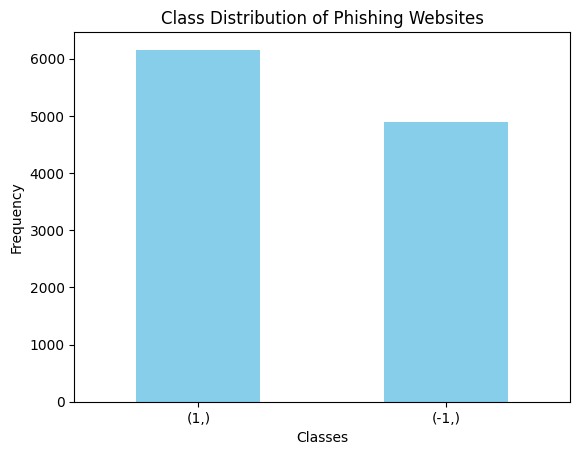

In [20]:
# TO DO: Check the class distribution of y (2 mark)
class_distribution = y.value_counts()
print("Class distribution of y:\n", class_distribution)

# Display exact values for each bin in the histogram
class_distribution.plot(kind='bar', color='skyblue')
plt.title('Class Distribution of Phishing Websites')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [21]:
from sklearn.model_selection import train_test_split
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print("Shape of X_small:", X_small.shape)
print("Shape of y_small:", y_small.shape)


Shape of X_small: (331, 30)
Shape of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [28]:
from sklearn.linear_model import LogisticRegression

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# a) Logistic regression with full X and y dataset
model.fit(X, y.values.ravel())
y_pred_full = model.predict(X)
accuracy_full = model.score(X, y.values.ravel())
print("Accuracy for full dataset:", accuracy_full)

# b) Logistic regression with first two columns of X and y
X_two_columns = X.iloc[:, :2]
model.fit(X_two_columns, y.values.ravel())
y_pred_two_columns = model.predict(X_two_columns)
accuracy_two_columns = model.score(X_two_columns, y.values.ravel())
print("Accuracy for first two columns:", accuracy_two_columns)

# c) Logistic regression with smaller dataset (X_small and y_small)
model.fit(X_small, y_small.values.ravel())
y_pred_small = model.predict(X_small)
accuracy_small = model.score(X_small, y_small.values.ravel())
print("Accuracy for smaller dataset:", accuracy_small)

Accuracy for full dataset: 0.9281772953414744
Accuracy for first two columns: 0.5610131162369968
Accuracy for smaller dataset: 0.945619335347432


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [38]:
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Function to calculate metrics for a given dataset
def evaluate_model(X_train, X_test, y_train, y_test):
    model = LogisticRegression(max_iter=2000)

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Training predictions and accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Testing predictions and accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Log Loss (on test data)
    test_log_loss = log_loss(y_test, y_test_pred)

    # Print results
    print(f"Data Size: {X_train.shape[0] + X_test.shape[0]}")
    print(f"Training Samples: {X_train.shape[0]}")
    print(f"Testing Samples: {X_test.shape[0]}")
    print(f"Training Accuracy: {train_accuracy}")
    print(f"Testing Accuracy: {test_accuracy}")
    print(f"Log Loss: {test_log_loss}")

    return train_accuracy, test_accuracy, test_log_loss

# a) Full dataset evaluation (Split into training and testing sets)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)
print("\nFull Dataset Evaluation:")
evaluate_model(X_train_full, X_test_full, y_train_full, y_test_full)

# b) First two columns evaluation
X_train_two_cols, X_test_two_cols, y_train_two_cols, y_test_two_cols = train_test_split(X.iloc[:, :2], y, test_size=0.3, random_state=42)
print("\nFirst Two Columns Dataset Evaluation:")
evaluate_model(X_train_two_cols, X_test_two_cols, y_train_two_cols, y_test_two_cols)

# c) Smaller dataset evaluation
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_small, y_small, test_size=0.3, random_state=42)
print("\nSmaller Dataset Evaluation:")
evaluate_model(X_train_small, X_test_small, y_train_small, y_test_small)



Full Dataset Evaluation:
Data Size: 11055
Training Samples: 7738
Testing Samples: 3317
Training Accuracy: 0.9311191522357198
Testing Accuracy: 0.9219173952366596
Log Loss: 2.814382341809268

First Two Columns Dataset Evaluation:
Data Size: 11055
Training Samples: 7738
Testing Samples: 3317
Training Accuracy: 0.5540191263892479
Testing Accuracy: 0.5773289116671692
Log Loss: 15.234610205469474

Smaller Dataset Evaluation:
Data Size: 331
Training Samples: 231
Testing Samples: 100
Training Accuracy: 0.948051948051948
Testing Accuracy: 0.93
Log Loss: 2.523055737238201


(0.948051948051948, 0.93, 2.523055737238201)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [ ]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



In [39]:
import pandas as pd

# Function to evaluate the model and compute required metrics, returning a dictionary
def evaluate_model(X, y):
    # Split the dataset into training (70%) and testing (30%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # If y is a DataFrame, convert to NumPy array
    y_train = y_train.values.ravel() if isinstance(y_train, pd.DataFrame) else y_train.ravel()
    y_test = y_test.values.ravel() if isinstance(y_test, pd.DataFrame) else y_test.ravel()

    # Instantiate and train the model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    # Predictions and accuracies for training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate Log Loss on the testing data
    test_log_loss = log_loss(y_test, y_test_pred)

    # Store metrics in a dictionary
    results = {
        "Data Size": X_train.shape[0] + X_test.shape[0],
        "Training Samples": X_train.shape[0],
        "Testing Samples": X_test.shape[0],
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Log Loss": test_log_loss
    }

    return results

# Evaluate the model on each dataset
full_results = evaluate_model(X, y)
two_columns_results = evaluate_model(X_two_columns, y)
small_results = evaluate_model(X_small, y_small)

# Create a DataFrame to store the results
results_df = pd.DataFrame([full_results, two_columns_results, small_results],
                          index=["Full Dataset", "First Two Columns", "Smaller Dataset"])

# Print the DataFrame
print(results_df)


                   Data Size  Training Samples  Testing Samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Smaller Dataset          331               231              100   

                   Training Accuracy  Testing Accuracy   Log Loss  
Full Dataset                0.932282          0.922822   2.781783  
First Two Columns           0.562807          0.556828  15.973521  
Smaller Dataset             0.943723          0.910000   3.243929  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [50]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model and get predictions for the test set
model = LogisticRegression(max_iter=2000)

# Convert y_train_full and y_test_full to NumPy arrays before applying .ravel()
model.fit(X_train_full, y_train_full.values.ravel())  # Use .values to convert to NumPy array, then .ravel()
y_test_pred = model.predict(X_test_full)

# Verify the dimensions of y_test and y_test_pred
print(f"y_test shape: {y_test_full.shape}")
print(f"y_test_pred shape: {y_test_pred.shape}")


y_test shape: (3317, 1)
y_test_pred shape: (3317,)


Confusion Matrix:
[[1298  130]
 [ 129 1760]]


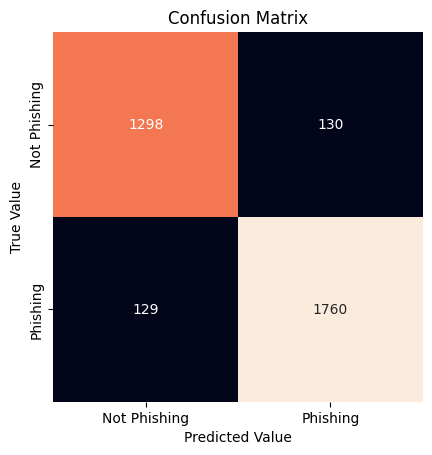

In [51]:
import seaborn as sns

# TO DO: Calculate confusion matrix (2 marks) : conf_mat

from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test_full, y_test_pred)

# Print confusion matrix to verify it
print("Confusion Matrix:")
print(conf_mat)


# Below code prints confusion matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix as a heatmap
sns.heatmap(conf_mat, xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'],
            square=True, annot=True, cbar=False, fmt='d')

# Add labels and title
plt.xlabel('Predicted Value')
plt.ylabel('True Value')
plt.title('Confusion Matrix')
plt.show()




In [52]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_full, y_test_pred, target_names=['Not Phishing', 'Phishing']))



Classification Report:
              precision    recall  f1-score   support

Not Phishing       0.91      0.91      0.91      1428
    Phishing       0.93      0.93      0.93      1889

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [53]:
# Question 1: Is the dataset imbalanced? Does it affect model performance?
# Answer:
# Yes, the dataset is slightly imbalanced with more "Phishing" cases (1889) than "Not Phishing" cases (1428).
# Imbalanced datasets can affect model performance by causing the model to be biased towards the majority class,
# potentially resulting in more false negatives or positives in the minority class. In this case, however,
# the model seems to handle the imbalance relatively well with good precision and recall for both classes.

# Question 2: Does the model overfit or underfit for each of the 3 cases?
# Answer:
# - Full Dataset: The model neither overfits nor underfits, with similar training (93%) and testing accuracy (92%).
# - First Two Columns Dataset: The model underfits here, as training accuracy is 55%, and testing accuracy is 56%.
#   This indicates that using only two features does not provide enough information for good model performance.
# - Smaller Dataset: The model performs well with training accuracy (94%) and testing accuracy (91%),
#   showing no significant overfitting or underfitting for this smaller dataset.

# Question 3: How do the training and testing accuracy change depending on the amount of data used? Explain with values.
# Answer:
# With the full dataset, the model achieves high accuracy for both training (93%) and testing (92%).
# When only using two columns, accuracy drops significantly to 55-56%, indicating insufficient feature information.
# With the smaller dataset, the accuracy remains high at 94% (training) and 91% (testing), indicating that the model
# performs well even with a reduced number of samples, assuming adequate feature information is present.

# Question 4: In this case, what do a false positive and a false negative represent? Which one is worse?
# Answer:
# - A false positive means an email is incorrectly classified as "Phishing" when it is "Not Phishing".
# - A false negative means an email is incorrectly classified as "Not Phishing" when it is "Phishing".
# A false negative is generally worse in this context because a phishing email that goes undetected can lead to
# security breaches or personal information theft, while a false positive is more of an inconvenience.

# Question 5: Based on your answer to question 4, would you want to maximize precision or recall? How would you do this?
# Answer:
# In this case, we would want to maximize **recall** for the "Phishing" class to ensure that as many phishing emails
# as possible are detected, minimizing the chance of false negatives. This can be achieved by tuning the decision threshold
# of the logistic regression model or focusing on recall during model evaluation and hyperparameter tuning.

# Question 6: Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance?
# What is potentially causing these differences?
# Answer:
# - Full Dataset: Log Loss is low (2.78), indicating that the model makes confident predictions with few incorrect classifications.
# - First Two Columns: Log Loss is high (15.97), indicating poor model performance due to insufficient feature information,
#   resulting in less confident and more incorrect predictions.
# - Smaller Dataset: Log Loss is slightly higher (3.24) compared to the full dataset but still acceptable, indicating
#   the model performs well even with fewer samples as long as sufficient features are provided.
# The differences in Log Loss are caused by the amount and quality of information available to the model:
# fewer features lead to less confident predictions and higher error rates.
